https://github.com/therealcyberlord/coronavirus_visualization_and_prediction/blob/master/coronavirus-covid-19-visualization-prediction.ipynb

source data: https://github.com/CSSEGISandData/COVID-19

In [0]:
import numpy as np 
import matplotlib as mpl
import matplotlib.pyplot as plt 
import matplotlib.colors as mcolors
import pandas as pd 
import random
import math
import time
import datetime
import operator
plt.style.use('seaborn')
%matplotlib inline


In [0]:
# 존스 홉킨스 데이터 다운로드
confirmed_df = pd.read_csv('https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_global.csv')
deaths_df = pd.read_csv('https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_deaths_global.csv')
recoveries_df = pd.read_csv('https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_recovered_global.csv')
confirmed_df.head()

,Province/State,Country/Region,Lat,Long,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,1/28/20,1/29/20,1/30/20,1/31/20,2/1/20,2/2/20,2/3/20,2/4/20,2/5/20,2/6/20,2/7/20,2/8/20,2/9/20,2/10/20,2/11/20,2/12/20,2/13/20,2/14/20,2/15/20,2/16/20,2/17/20,2/18/20,2/19/20,2/20/20,2/21/20,2/22/20,2/23/20,2/24/20,2/25/20,2/26/20,2/27/20,2/28/20,2/29/20,3/1/20,3/2/20,3/3/20,3/4/20,3/5/20,3/6/20,3/7/20,3/8/20,3/9/20,3/10/20,3/11/20,3/12/20,3/13/20,3/14/20,3/15/20,3/16/20,3/17/20,3/18/20,3/19/20,3/20/20,3/21/20,3/22/20,3/23/20,3/24/20,3/25/20,3/26/20,3/27/20,3/28/20,3/29/20,3/30/20,3/31/20
0,NaN,Afghanistan,33.0000,65.0000,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,1,1,1,1,1,1,1,1,1,4,4,5,7,7,7,11,16,21,22,22,22,24,24,40,40,74,84,94,110,110,120,170,174
1,NaN,Albania,41.1533,20.1683,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,10,12,23,33,38,42,51,55,59,64,70,76,89,104,123,146,174,186,197,212,223,243
2,NaN,Algeria,28.0339,1.6596,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,1,1,3,5,12,12,17,17,19,20,20,20,24,26,37,48,54,60,74,87,90,139,201,230,264,302,367,409,454,511,584,716
3,NaN,Andorra,42.5063,1.5218,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,2,39,39,53,75,88,113,133,164,188,224,267,308,334,370,376
4,NaN,Angola,-11.2027,17.8739,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,2,2,3,3,3,4,4,5,7,7,7


In [0]:
cols = confirmed_df.keys()
cols

Index(['Province/State', 'Country/Region', 'Lat', 'Long', '1/22/20', '1/23/20',
       '1/24/20', '1/25/20', '1/26/20', '1/27/20', '1/28/20', '1/29/20',
       '1/30/20', '1/31/20', '2/1/20', '2/2/20', '2/3/20', '2/4/20', '2/5/20',
       '2/6/20', '2/7/20', '2/8/20', '2/9/20', '2/10/20', '2/11/20', '2/12/20',
       '2/13/20', '2/14/20', '2/15/20', '2/16/20', '2/17/20', '2/18/20',
       '2/19/20', '2/20/20', '2/21/20', '2/22/20', '2/23/20', '2/24/20',
       '2/25/20', '2/26/20', '2/27/20', '2/28/20', '2/29/20', '3/1/20',
       '3/2/20', '3/3/20', '3/4/20', '3/5/20', '3/6/20', '3/7/20', '3/8/20',
       '3/9/20', '3/10/20', '3/11/20', '3/12/20', '3/13/20', '3/14/20',
       '3/15/20', '3/16/20', '3/17/20', '3/18/20', '3/19/20', '3/20/20',
       '3/21/20', '3/22/20', '3/23/20', '3/24/20', '3/25/20', '3/26/20',
       '3/27/20', '3/28/20', '3/29/20', '3/30/20', '3/31/20'],
      dtype='object')

In [0]:
# 일일 데이터만 추출('Province/State', 'Country/Region', 'Lat', 'Long' 컬럼 제외)
confirmed = confirmed_df.loc[:, cols[4]:cols[-1]]
deaths = deaths_df.loc[:, cols[4]:cols[-1]]
recoveries = recoveries_df.loc[:, cols[4]:cols[-1]]


In [0]:
dates = confirmed.keys()
print(dates)
adjusted_dates = np.array([i for i in range(len(dates))]).reshape(-1, 1)


Index(['1/22/20', '1/23/20', '1/24/20', '1/25/20', '1/26/20', '1/27/20',
       '1/28/20', '1/29/20', '1/30/20', '1/31/20', '2/1/20', '2/2/20',
       '2/3/20', '2/4/20', '2/5/20', '2/6/20', '2/7/20', '2/8/20', '2/9/20',
       '2/10/20', '2/11/20', '2/12/20', '2/13/20', '2/14/20', '2/15/20',
       '2/16/20', '2/17/20', '2/18/20', '2/19/20', '2/20/20', '2/21/20',
       '2/22/20', '2/23/20', '2/24/20', '2/25/20', '2/26/20', '2/27/20',
       '2/28/20', '2/29/20', '3/1/20', '3/2/20', '3/3/20', '3/4/20', '3/5/20',
       '3/6/20', '3/7/20', '3/8/20', '3/9/20', '3/10/20', '3/11/20', '3/12/20',
       '3/13/20', '3/14/20', '3/15/20', '3/16/20', '3/17/20', '3/18/20',
       '3/19/20', '3/20/20', '3/21/20', '3/22/20', '3/23/20', '3/24/20',
       '3/25/20', '3/26/20', '3/27/20', '3/28/20', '3/29/20', '3/30/20',
       '3/31/20'],
      dtype='object')


In [0]:
latest_confirmed = confirmed_df[dates[-1]]
latest_deaths = deaths_df[dates[-1]]
latest_recoveries = recoveries_df[dates[-1]]


In [0]:
# 국가 리스트 및 국가별 인구 수
TOP_N = 16  # 확진자 상위 국가 N
unique_countries = list(confirmed_df['Country/Region'].unique())
country_confirmed_cases = []
no_cases = []
for i in unique_countries:
    cases = latest_confirmed[confirmed_df['Country/Region'] == i].sum()
    if cases > 0:
        country_confirmed_cases.append(cases)
    else:
        no_cases.append(i)

for i in no_cases:
    unique_countries.remove(i)

unique_countries = [k for k, v in
                    sorted(zip(unique_countries, country_confirmed_cases), key=operator.itemgetter(1), reverse=True)]
unique_countries = unique_countries[:TOP_N]

print(unique_countries)

population = {'China':1399620000,
 'Italy':60278616,
 'US':330093000,
 'Spain':46934632,
 'Germany':83073100,
 'Iran':82878200,
 'France':67055000,
 'Korea, South':51851427,
 'Switzerland':8544034,
 'United Kingdom':66435600,
 'Netherlands':17084459,
 'Japan':126150000,
 'Netherlands':17084459,
 'Austria':8751820,
 'Belgium':11498519,
 'Canada':36954000,
 'Turkey':82600000,
 'Portugal':10291027
}


['US', 'Italy', 'Spain', 'China', 'Germany', 'France', 'Iran', 'United Kingdom', 'Switzerland', 'Turkey', 'Belgium', 'Netherlands', 'Austria', 'Korea, South', 'Canada', 'Portugal']


In [0]:
for i in range(len(unique_countries)):
    country_confirmed_cases[i] = latest_confirmed[confirmed_df['Country/Region'] == unique_countries[i]].sum()
visual_unique_countries = []
visual_confirmed_cases = []
for i in range(len(country_confirmed_cases[:TOP_N])):
    visual_unique_countries.append(unique_countries[i])
    visual_confirmed_cases.append(country_confirmed_cases[i])

list(zip(visual_unique_countries, visual_confirmed_cases))

[('US', 188172),
 ('Italy', 105792),
 ('Spain', 95923),
 ('China', 82279),
 ('Germany', 71808),
 ('France', 52827),
 ('Iran', 44605),
 ('United Kingdom', 25481),
 ('Switzerland', 16605),
 ('Turkey', 13531),
 ('Belgium', 12775),
 ('Netherlands', 12667),
 ('Austria', 10180),
 ('Korea, South', 9786),
 ('Canada', 8527),
 ('Portugal', 7443)]

국가별 누적 확진자 수평 막대 그래프

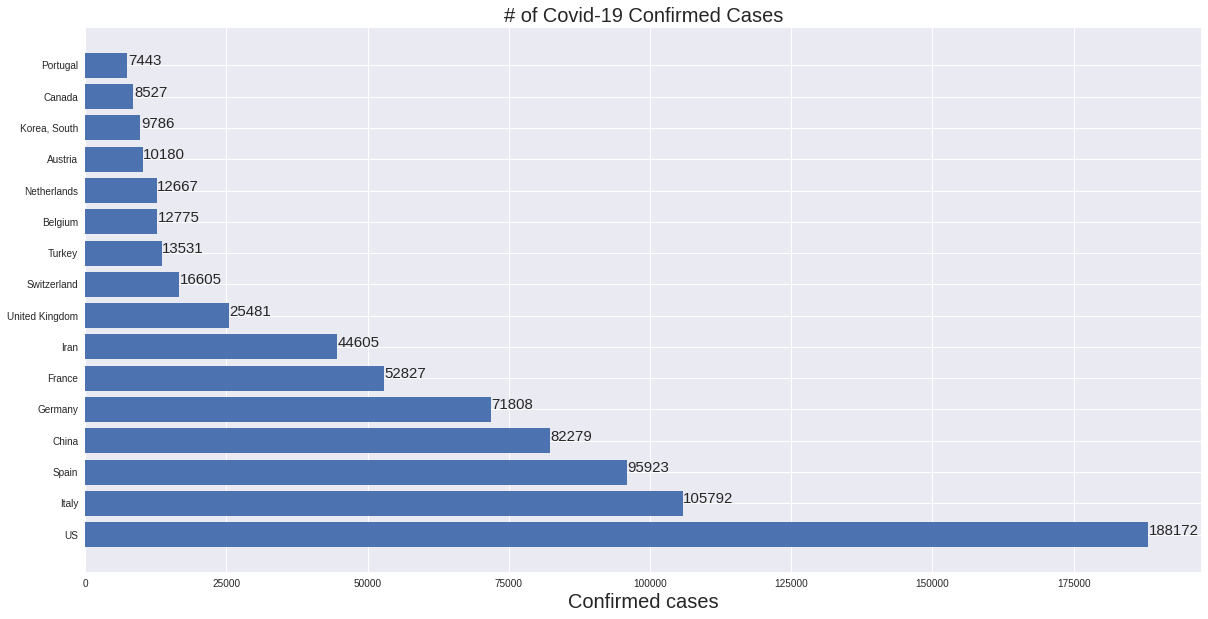

In [0]:
plt.figure(figsize=(20, 10))
plt.barh(visual_unique_countries, visual_confirmed_cases)
plt.xlabel('Confirmed cases', size=20)
plt.title('# of Covid-19 Confirmed Cases', size=20)
for i, case in enumerate(visual_confirmed_cases):
  plt.annotate(xy=[case + 100,i], s=case, size=15)


인구 수 10만명 당 확진자 수

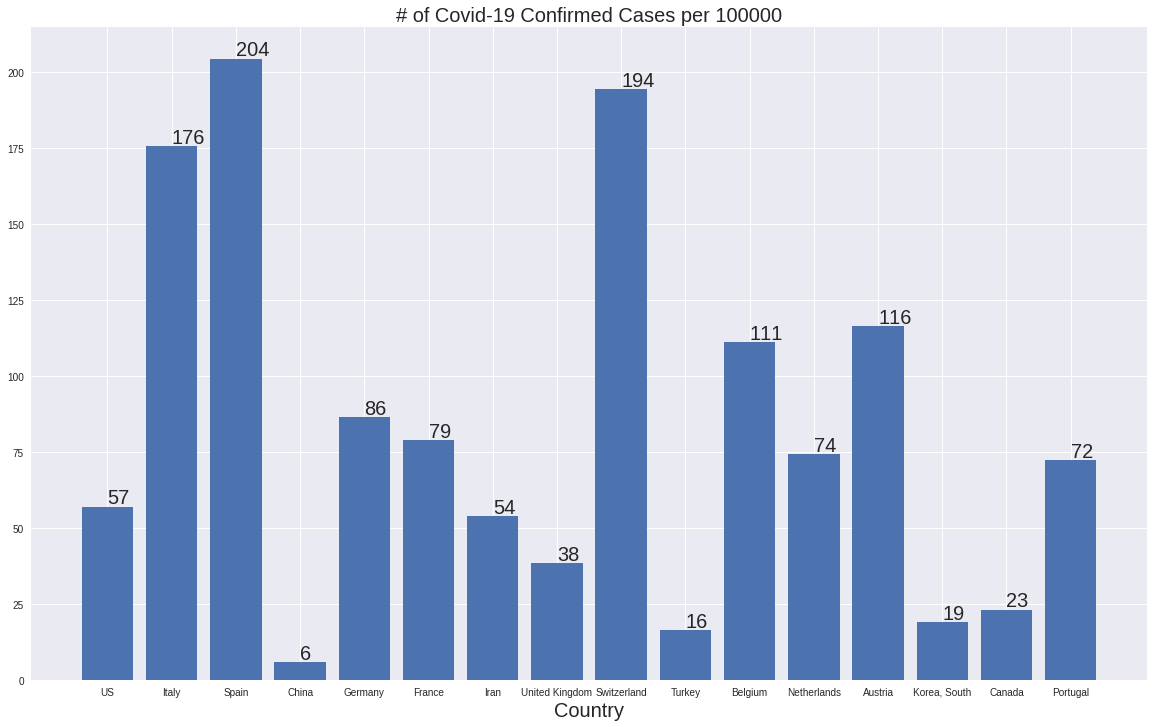

In [0]:
plt.figure(figsize=(20, 12))
v_unique_countries = visual_unique_countries
#v_unique_countries = visual_unique_countries + ['Japan']
visual_confirmed_cases = []
for i in range(len(v_unique_countries)):
    visual_confirmed_cases.append(latest_confirmed[confirmed_df['Country/Region'] == v_unique_countries[i]].sum())
population_confirmed_cases = []
for country, case in zip(v_unique_countries, visual_confirmed_cases):
  population_confirmed_cases.append(case * 100000 / population[country])
plt.bar(v_unique_countries, population_confirmed_cases)
plt.xlabel('Country', size=20)
plt.title('# of Covid-19 Confirmed Cases per 100000', size=20)
for i, case in enumerate(population_confirmed_cases):
  plt.annotate(xy=[i, case + 1], s='{:.0f}'.format(case), size=20)

국가별 사망률

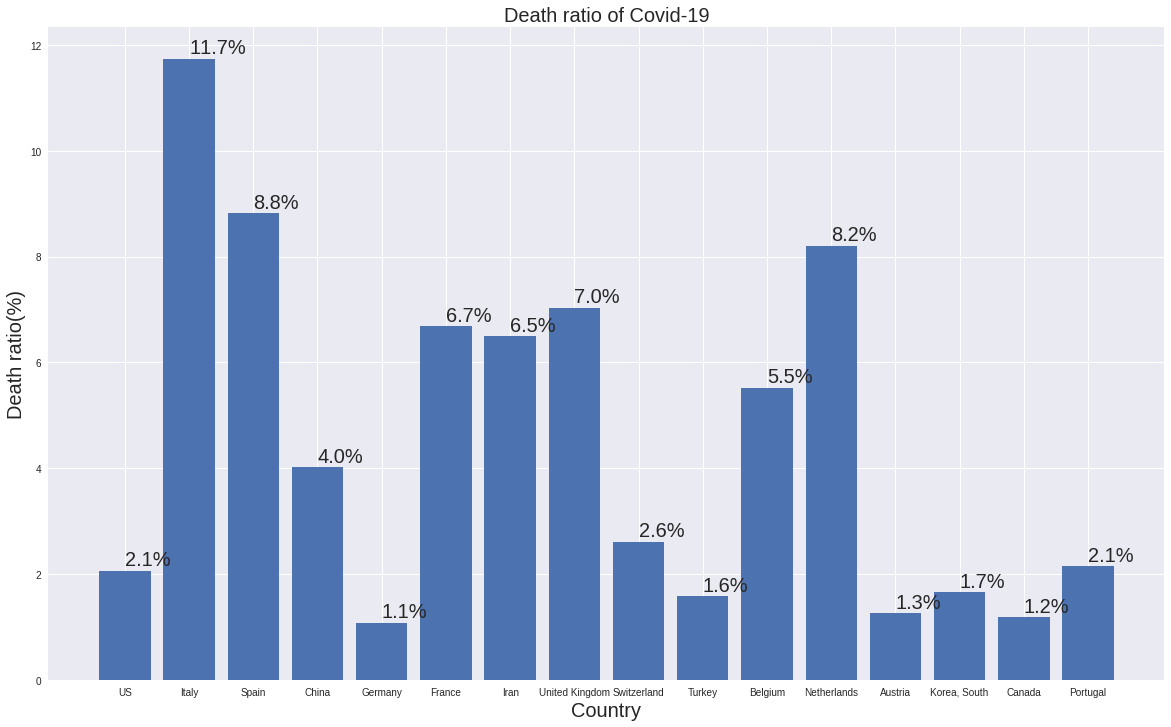

In [0]:
plt.figure(figsize=(20, 12))
# v_unique_countries = visual_unique_countries + ['Japan']
death_ratios = []
for i in range(len(v_unique_countries)):
  ratio = (latest_deaths[deaths_df['Country/Region'] == v_unique_countries[i]].sum() * 100)  / latest_confirmed[confirmed_df['Country/Region'] == v_unique_countries[i]].sum()
  death_ratios.append(ratio)

plt.bar(v_unique_countries, death_ratios)
plt.xlabel('Country', size=20)
plt.ylabel('Death ratio(%)', size=20)
plt.title('Death ratio of Covid-19', size=20)
for i, ratio in enumerate(death_ratios):
  plt.annotate(xy=[i, ratio + 0.1], s='{:.1f}%'.format(ratio), size=20)


국가별 확진자 상대 비율(파이 챠트)

Text(0.5, 1.0, 'Ratio of Covid-19 Confirmed Cases')

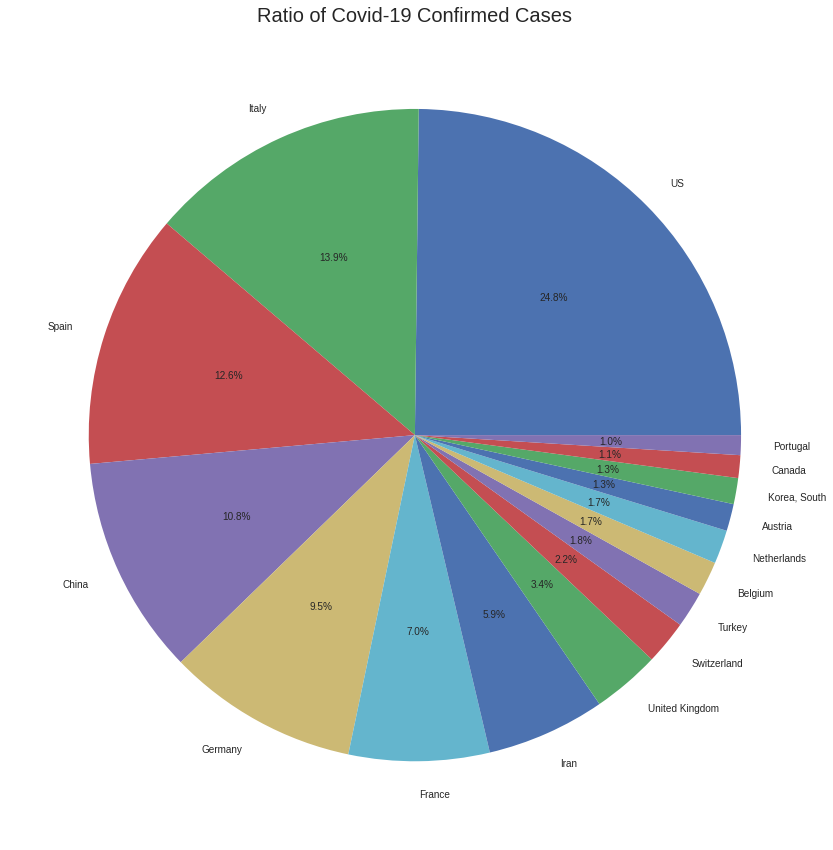

In [0]:
plt.figure(figsize=(20, 15))
plt.pie(visual_confirmed_cases, labels=visual_unique_countries,autopct='%1.1f%%')
plt.title('Ratio of Covid-19 Confirmed Cases', size=20)

전체 누적 확진자 및 신규 확진자

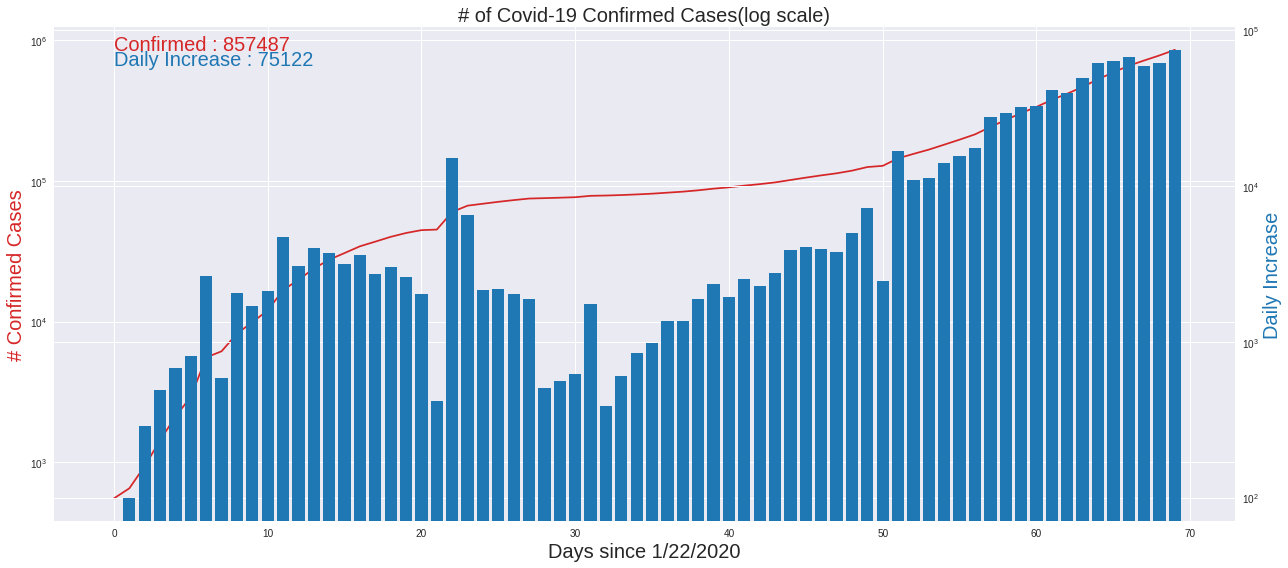

In [0]:
adjusted_dates = [i for i in range(len(dates))]

cases = confirmed.sum(axis=0)
color = 'tab:red'
fig, ax1 = plt.subplots(figsize=(18, 8))
ax1.set_yscale('log')
ax1.plot(adjusted_dates, cases, color=color)
ax1.set_xlabel('Days since 1/22/2020', size=20)
ax1.set_ylabel('# Confirmed Cases', color=color, size=20)
ax1.text(0, cases[-1], 'Confirmed : {}'.format(cases[-1]), size=20, color=color)
new_cases = [0]
for i, case in enumerate(cases[:-1]):
  new_cases.append(cases[i + 1] - cases[i])

ax2 = ax1.twinx()
color = 'tab:blue'
ax2.set_yscale('log')
ax2.bar(adjusted_dates, new_cases, color=color)
ax2.set_ylabel('Daily Increase', color=color, size=20)
ax2.text(0, new_cases[-1] * 0.8, 'Daily Increase : {}'.format(new_cases[-1]), size=20, color=color)
plt.title('# of Covid-19 Confirmed Cases(log scale)', size=20)

fig.tight_layout()


국가별 신규 확진자 추이

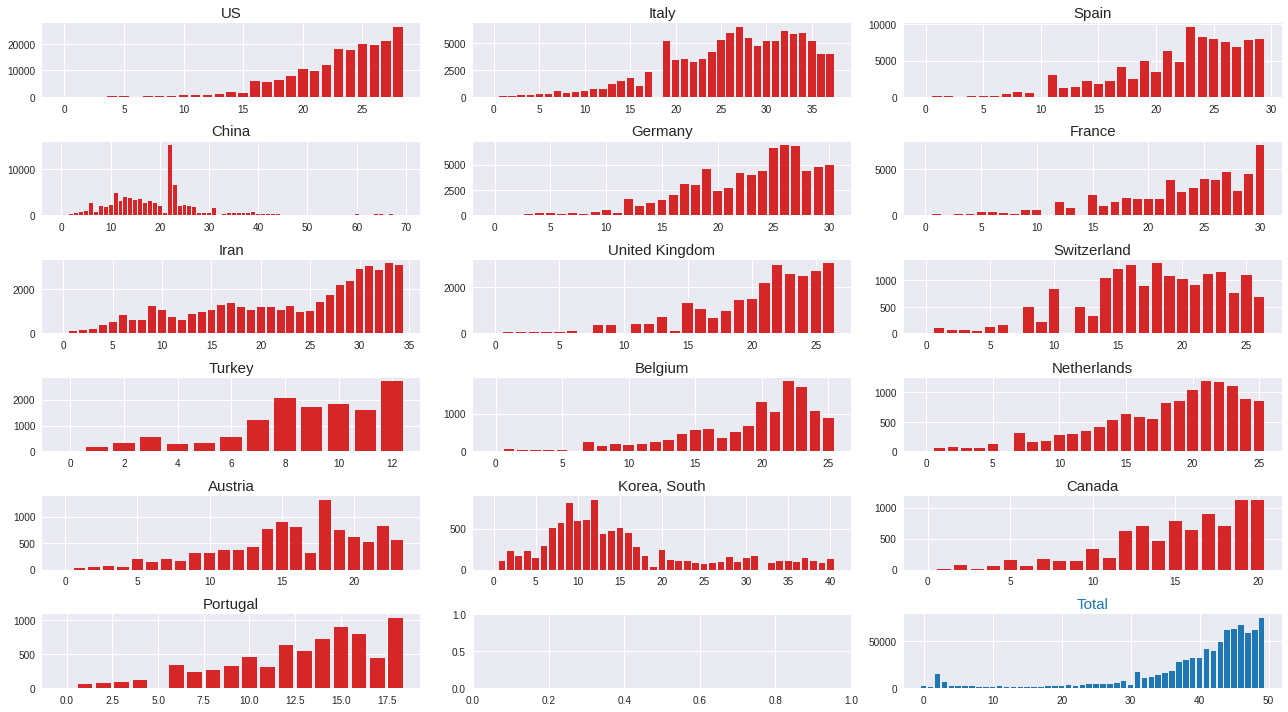

In [0]:
color = 'tab:red'
fig, axs = plt.subplots(6, 3, figsize=(18, 10))
#fig.suptitle('# of Covid-19 Daily Increase', size=10)
for index, country in enumerate(v_unique_countries):
  cases = confirmed_df.loc[confirmed_df['Country/Region'] == country, cols[4]:cols[-1]].sum()
  cases = [c for c in cases if c > 100]
  adjusted_dates = [i for i in range(len(cases))]
  new_cases =[0]
  for i, case in enumerate(cases[:-1]):
    new_cases.append(cases[i + 1] - cases[i])
  row, col = divmod(index, 3)
  axs[row, col].bar(adjusted_dates, new_cases, color=color)
  axs[row, col].set_title(country, size=15)

total_cases = confirmed.sum()
new_cases =[0]
for i, case in enumerate(total_cases[:-1]):
  new_cases.append(total_cases[i + 1] - total_cases[i])
new_cases = new_cases[20:]
adjusted_dates = [i for i in range(len(new_cases))]
color = 'tab:blue'
axs[5, 2].bar(adjusted_dates, new_cases, color=color)
axs[5, 2].set_title('Total', size=15, color=color)

fig.tight_layout()

국가별 누적 확진자 증가율

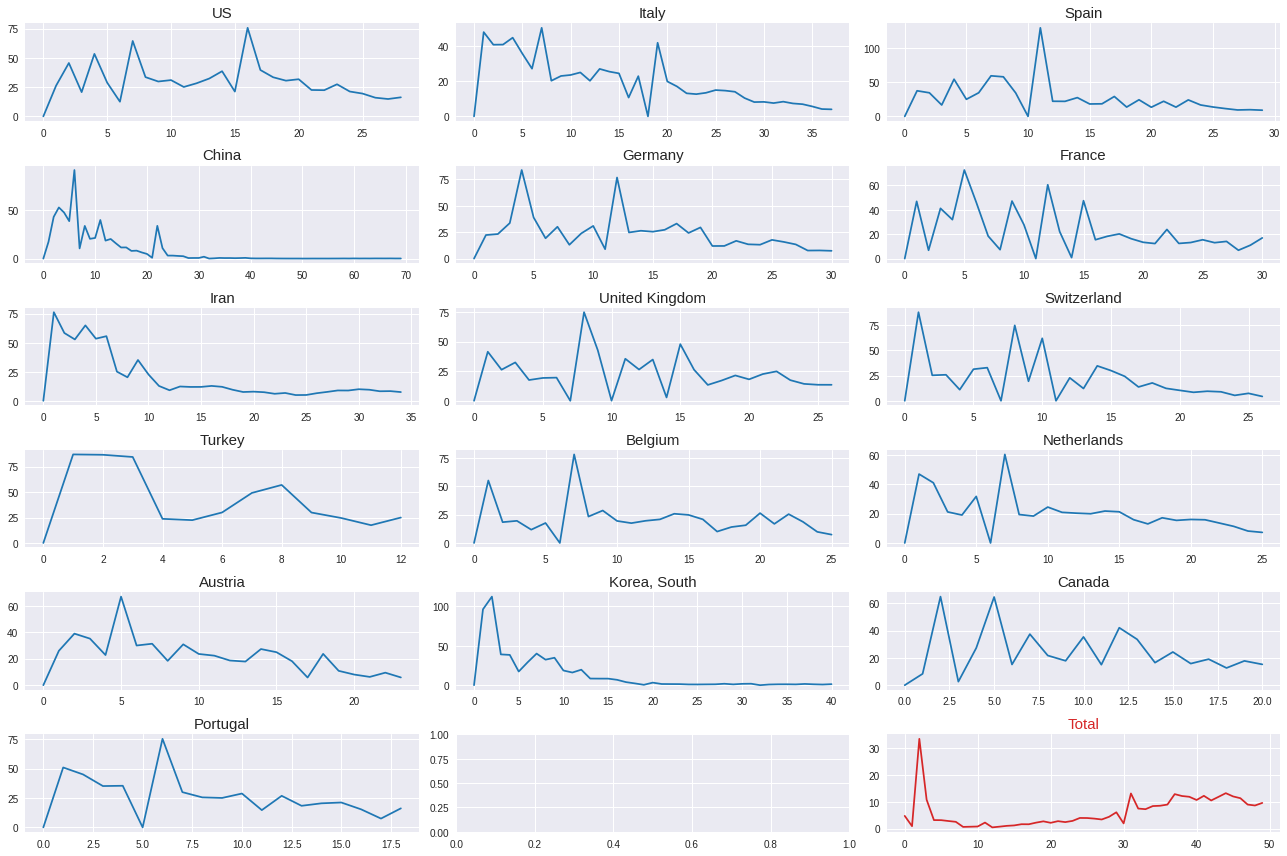

In [0]:
color = 'tab:blue'
fig, axs = plt.subplots(6, 3, figsize=(18, 12))
#fig.suptitle('# of Covid-19 Daily Increase', size=10)
for index, country in enumerate(v_unique_countries):
  cases = confirmed_df.loc[confirmed_df['Country/Region'] == country, cols[4]:cols[-1]].sum()
  cases = [c for c in cases if c > 100]
  adjusted_dates = [i for i in range(len(cases))]
  new_cases =[0]
  for i, case in enumerate(cases[:-1]):
    new_cases.append((cases[i + 1] - cases[i]) * 100 / cases[i])
  row, col = divmod(index, 3)
  axs[row, col].plot(adjusted_dates, new_cases, color=color)
  axs[row, col].set_title(country, size=15)

total_cases = confirmed.sum()
new_cases =[0]
for i, case in enumerate(total_cases[:-1]):
  new_cases.append((total_cases[i + 1] - total_cases[i]) * 100 /total_cases[i])
new_cases = new_cases[20:]
adjusted_dates = [i for i in range(len(new_cases))]
color = 'tab:red'
axs[5, 2].plot(adjusted_dates, new_cases, color=color)
axs[5, 2].set_title('Total', size=15, color=color)

fig.tight_layout()

국가별 일일 사망률 추이

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in long_scalars
  if __name__ == '__main__':


(array([-10.,   0.,  10.,  20.,  30.,  40.,  50.]),
 <a list of 7 Text major ticklabel objects>)

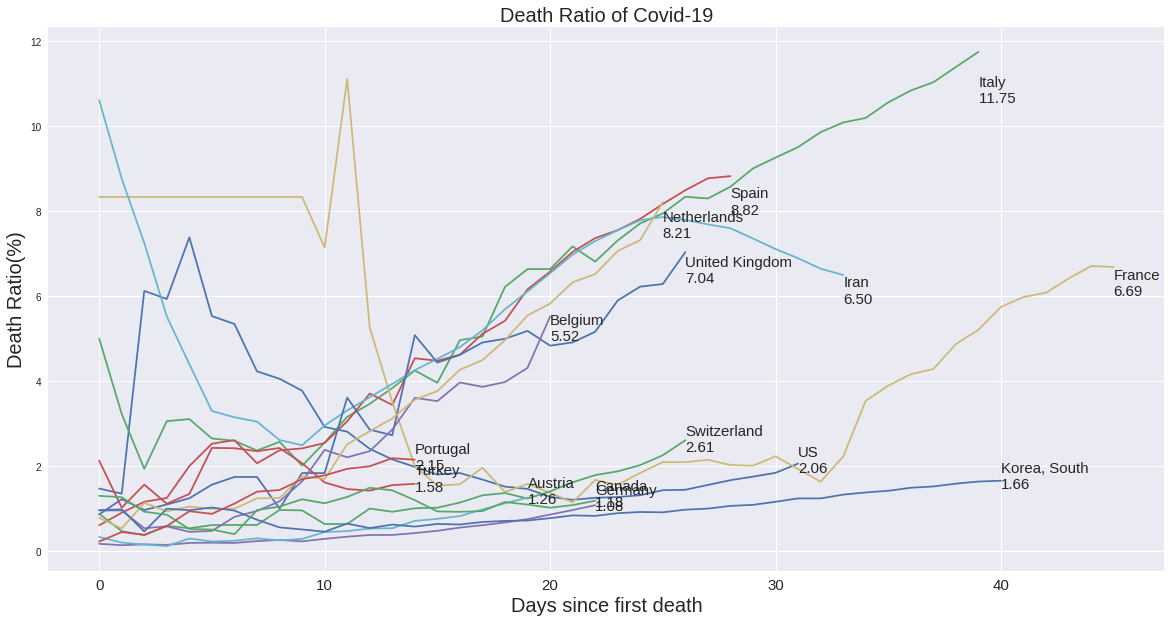

In [0]:
plt.figure(figsize=(20, 10))
for country in v_unique_countries:
  if country == 'China':
    continue
  cases = confirmed_df.loc[confirmed_df['Country/Region'] == country, cols[4]:cols[-1]].sum()
  death_cases = deaths_df.loc[deaths_df['Country/Region'] == country, cols[4]:cols[-1]].sum()
  deaths_ratio =[]
  for i, case in enumerate(cases):
    deaths_ratio.append(death_cases[i] * 100 / cases[i])
  deaths_ratio = [d for d in deaths_ratio if 0 < d < 13]
  adjusted_dates = [i for i in range(len(deaths_ratio))]
  plt.plot(deaths_ratio)
  plt.annotate(xy=[len(deaths_ratio)-1,deaths_ratio[-1] * 0.9], s=country + '\n' + '{:.2f}'.format(deaths_ratio[-1]), size=15)
plt.title('Death Ratio of Covid-19', size=20)
plt.xlabel('Days since first death', size=20)
plt.ylabel('Death Ratio(%)', size=20)
plt.xticks(size=15)

국가별 사망자 수 추이

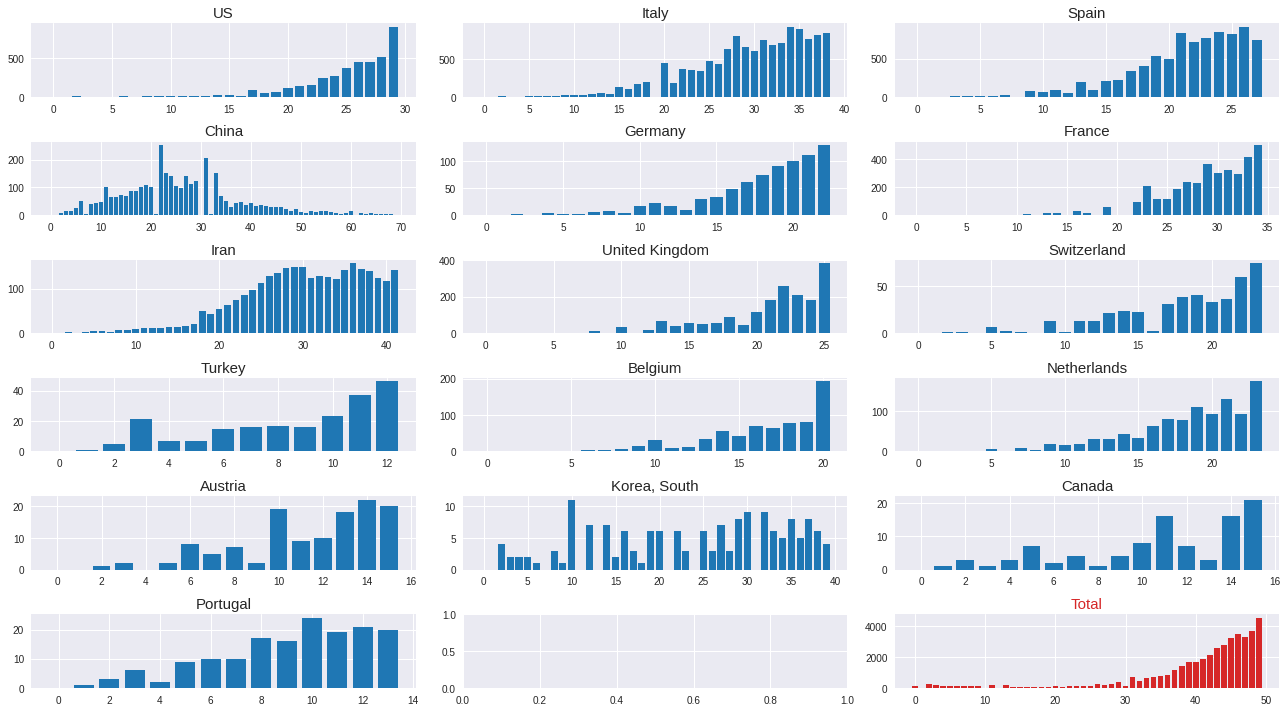

In [0]:
color = 'tab:blue'
fig, axs = plt.subplots(6, 3, figsize=(18, 10))
#fig.suptitle('# of Covid-19 Daily Increase', size=10)
for index, country in enumerate(v_unique_countries):
  cases = deaths_df.loc[confirmed_df['Country/Region'] == country, cols[4]:cols[-1]].sum()
  cases = [c for c in cases if c > 1]
  adjusted_dates = [i for i in range(len(cases))]
  new_cases =[0]
  for i, case in enumerate(cases[:-1]):
    new_cases.append(cases[i + 1] - cases[i])
  row, col = divmod(index, 3)
  axs[row, col].bar(adjusted_dates, new_cases, color=color)
  axs[row, col].set_title(country, size=15)

total_cases = deaths.sum()
new_cases =[0]
for i, case in enumerate(total_cases[:-1]):
  new_cases.append(total_cases[i + 1] - total_cases[i])
new_cases = new_cases[20:]
adjusted_dates = [i for i in range(len(new_cases))]
color = 'tab:red'
axs[5, 2].bar(adjusted_dates, new_cases, color=color)
axs[5, 2].set_title('Total', size=15, color=color)

fig.tight_layout()

이탈리아 일별 누적 확진자/신규 확진자 수

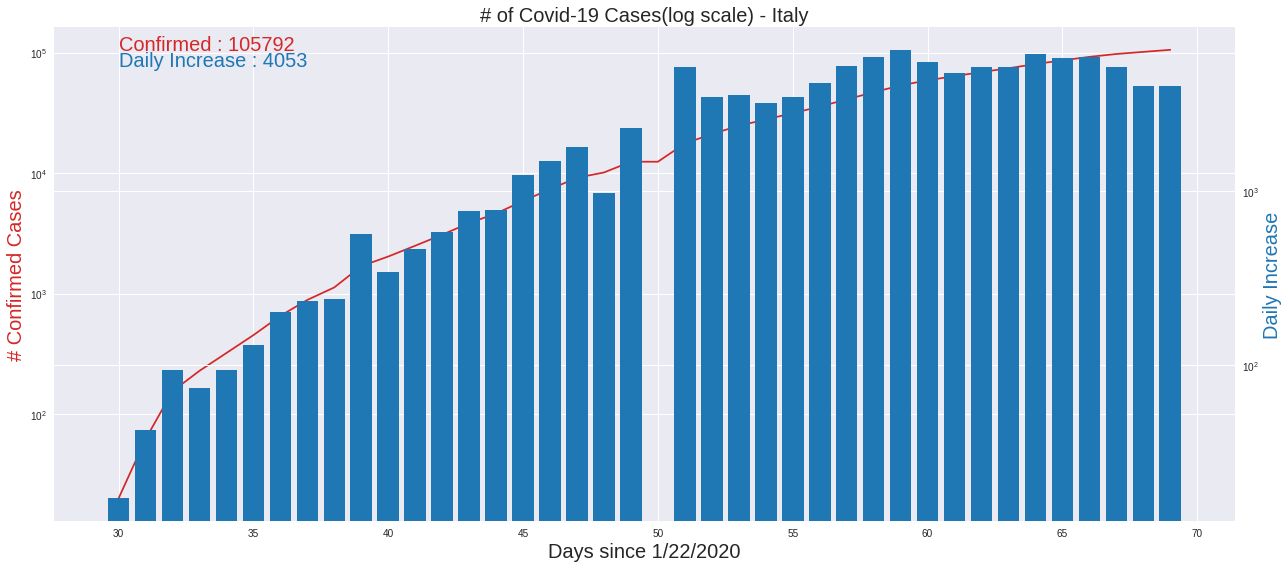

In [0]:
adjusted_dates = [i for i in range(len(dates))]
start =30
cases = confirmed_df.loc[confirmed_df['Country/Region'] == 'Italy', cols[4]:cols[-1]].sum()
cases = cases.values.reshape(len(dates))
color = 'tab:red'
fig, ax1 = plt.subplots(figsize=(18, 8))
ax1.set_yscale('log')
ax1.plot(adjusted_dates[start:], cases[start:], color=color)
ax1.set_xlabel('Days since 1/22/2020', size=20)
ax1.set_ylabel('# Confirmed Cases', color=color, size=20)
ax1.text(start, cases[-1], 'Confirmed : {}'.format(cases[-1]), size=20, color=color)
new_cases = [0]
for i, case in enumerate(cases[:-1]):
  new_cases.append(cases[i + 1] - cases[i])

ax2 = ax1.twinx()
color = 'tab:blue'
ax2.set_yscale('log')
ax2.bar(adjusted_dates[start:], new_cases[start:], color=color)
ax2.set_ylabel('Daily Increase', color=color, size=20)
ax2.text(start, max(new_cases) * 0.8, 'Daily Increase : {}'.format(new_cases[-1]), size=20, color=color)

plt.title('# of Covid-19 Cases(log scale) - Italy', size=20)
fig.tight_layout()

미국 추이

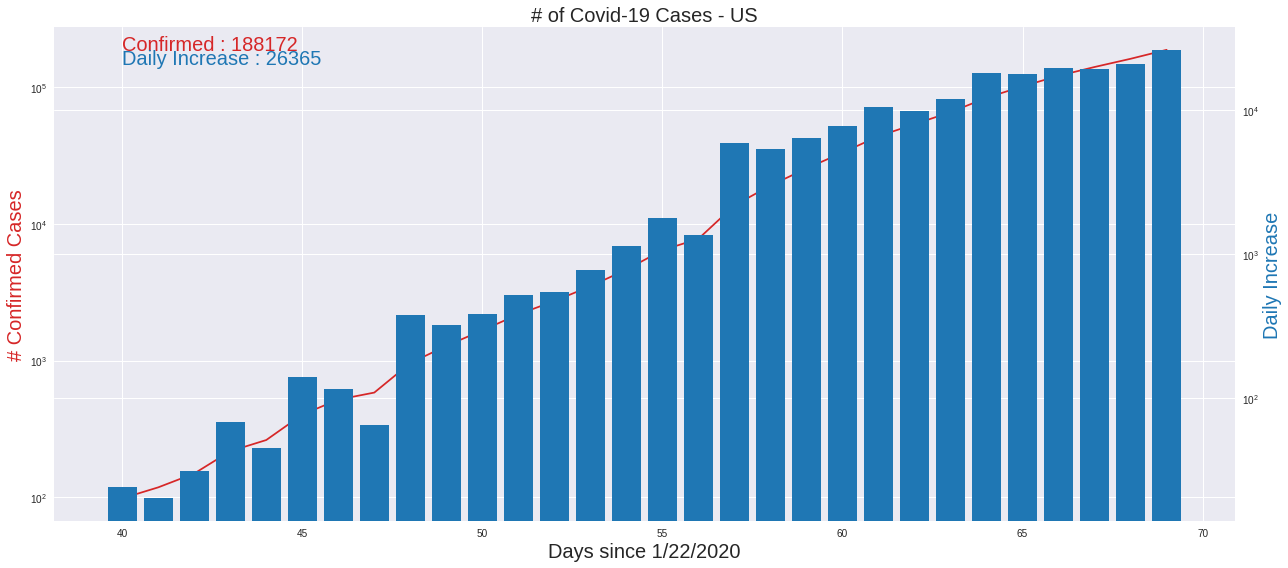

In [0]:
adjusted_dates = [i for i in range(len(dates))]

cases = confirmed_df.loc[confirmed_df['Country/Region'] == 'US', cols[4]:cols[-1]].sum()
cases = cases.values.reshape(len(dates))
color = 'tab:red'
fig, ax1 = plt.subplots(figsize=(18, 8))
ax1.set_yscale('log')
ax1.plot(adjusted_dates[40:], cases[40:], color=color)
ax1.set_xlabel('Days since 1/22/2020', size=20)
ax1.set_ylabel('# Confirmed Cases', color=color, size=20)
ax1.text(40, cases[-1], 'Confirmed : {}'.format(cases[-1]), size=20, color=color)
new_cases = [0]
for i, case in enumerate(cases[:-1]):
  new_cases.append(cases[i + 1] - cases[i])

ax2 = ax1.twinx()
color = 'tab:blue'
ax2.set_yscale('log')
ax2.bar(adjusted_dates[40:], new_cases[40:], color=color)
ax2.set_ylabel('Daily Increase', color=color, size=20)
ax2.text(40, max(new_cases) * 0.8, 'Daily Increase : {}'.format(new_cases[-1]), size=20, color=color)

plt.title('# of Covid-19 Cases - US', size=20)
fig.tight_layout()

국가별,일별 누적 확진자 그래프(중국 제외)


(array([10., 20., 30., 40., 50., 60., 70., 80.]),
 <a list of 8 Text major ticklabel objects>)

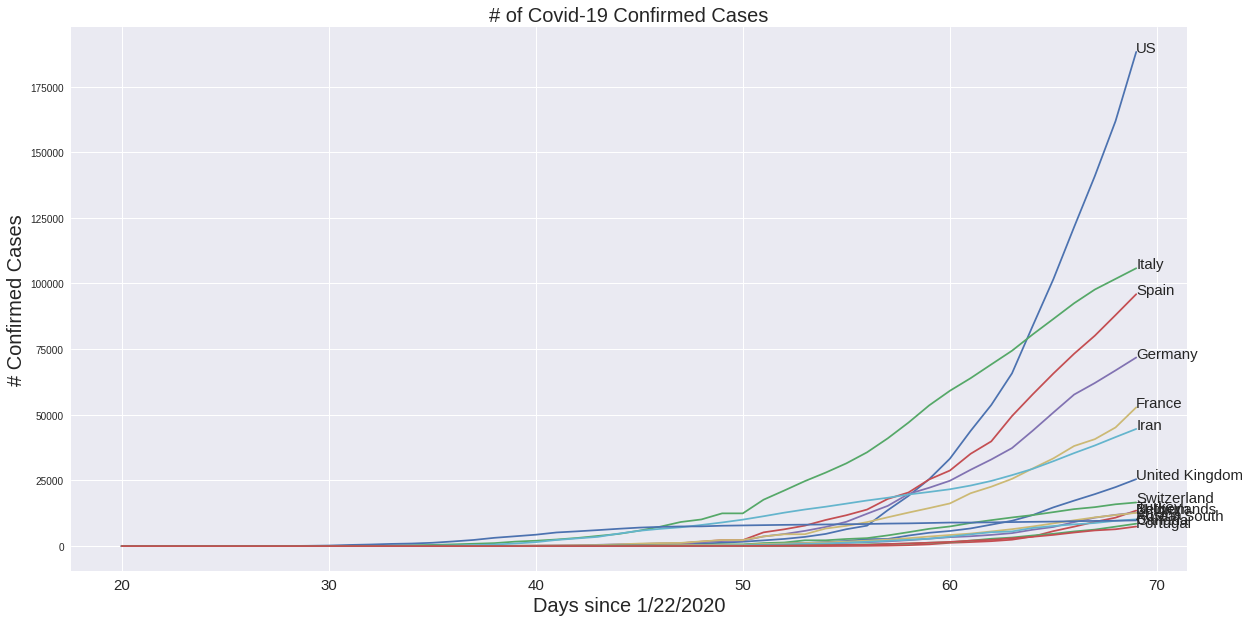

In [0]:
adjusted_dates = np.array([i for i in range(len(dates))]).reshape(-1, 1)
adjusted_dates = adjusted_dates[20:]

plt.figure(figsize=(20, 10))
for i, country in enumerate(unique_countries):
  if country == 'China':
    continue
  country_confirmed_cases = confirmed_df.loc[confirmed_df['Country/Region'] == country, cols[4]:cols[-1]].sum()
  country_confirmed_cases = country_confirmed_cases.values.reshape(len(dates))
  # country_confirmed_cases = [confirmed for confirmed in country_confirmed_cases if confirmed > 100]
  plt.plot(adjusted_dates, country_confirmed_cases[20:])
  plt.annotate(xy=[len(adjusted_dates) + 19,country_confirmed_cases[-1]], s=country, size=15)
plt.title('# of Covid-19 Confirmed Cases', size=20)
plt.xlabel('Days since 1/22/2020', size=20)
plt.ylabel('# Confirmed Cases', size=20)

plt.xticks(size=15)


확진자 100명 이후 경과일수에 따른 확진자 추이(중국 제외)

(array([-5.,  0.,  5., 10., 15., 20., 25., 30., 35., 40., 45.]),
 <a list of 11 Text major ticklabel objects>)

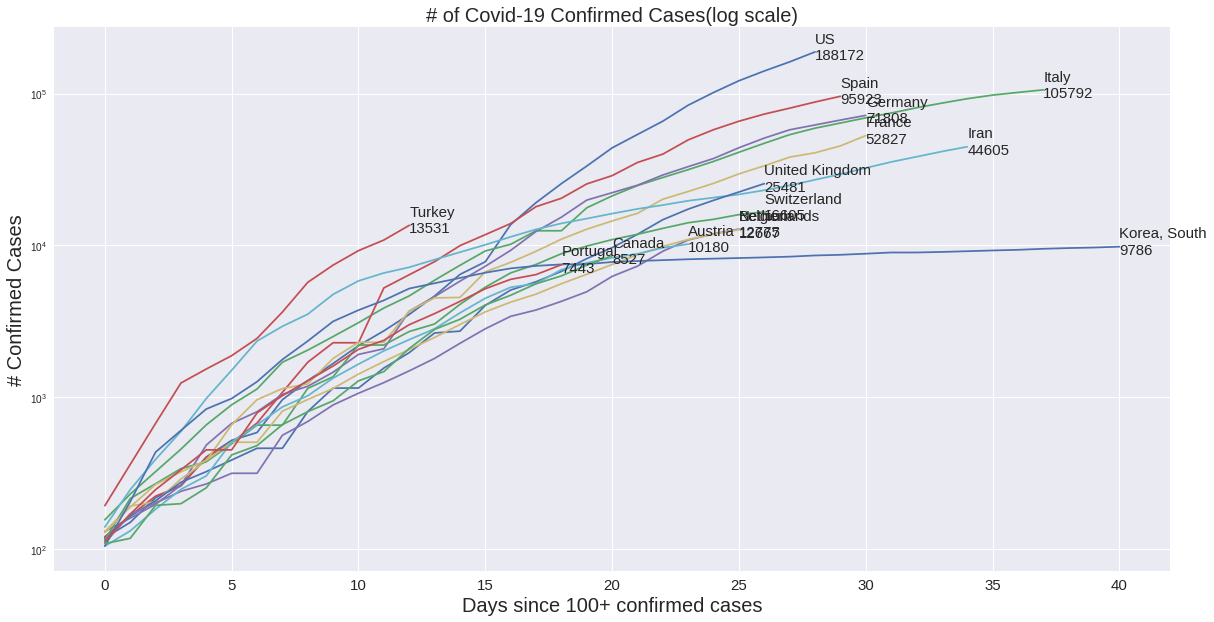

In [0]:
plt.figure(figsize=(20, 10))
plt.yscale('log')
for country in v_unique_countries:
  if country == 'China':
    continue
  country_confirmed_cases = confirmed_df.loc[confirmed_df['Country/Region'] == country, cols[4]:cols[-1]].sum()
  country_confirmed_cases = country_confirmed_cases.values.reshape(len(dates))
  country_confirmed_cases = [confirmed for confirmed in country_confirmed_cases if confirmed > 100]
  plt.plot(country_confirmed_cases)
  plt.annotate(xy=[len(country_confirmed_cases)-1,country_confirmed_cases[-1] * 0.9], s=country + '\n' + str(country_confirmed_cases[-1]), size=15)
plt.title('# of Covid-19 Confirmed Cases(log scale)', size=20)
plt.xlabel('Days since 100+ confirmed cases', size=20)
plt.ylabel('# Confirmed Cases', size=20)
# plt.legend(v_unique_countries, loc='upper left')
plt.xticks(size=15)

국내 확진자/격리중/완치자/사망자

(array([10., 20., 30., 40., 50., 60., 70., 80.]),
 <a list of 8 Text major ticklabel objects>)

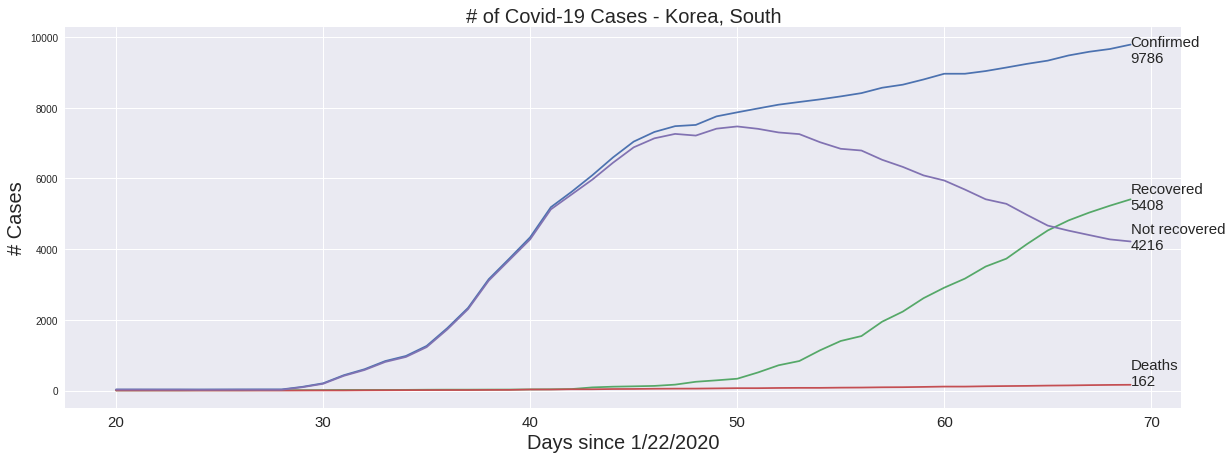

In [0]:
# 홉킨스 완치자 한국 데이터가 일부 부정확해 일단 하드코딩 처리
recovered_korea = [
                   ('1/22/20',0), 
                   ('1/23/20',0),
                   ('1/24/20',0), 
                   ('1/25/20',0), 
                   ('1/26/20',0), 
                   ('1/27/20',0), 
                   ('1/28/20',0), 
                   ('1/29/20',0),
                   ('1/30/20',0), 
                   ('1/31/20',0), 
                   ('2/1/20',0), 
                   ('2/2/20',0), 
                   ('2/3/20',0), 
                   ('2/4/20',0), 
                   ('2/5/20',0),
                   ('2/6/20',0), 
                   ('2/7/20',0), 
                   ('2/8/20',0), 
                   ('2/9/20',0), 
                   ('2/10/20',0), 
                   ('2/11/20',3), 
                   ('2/12/20',3),
                   ('2/13/20',4), 
                   ('2/14/20',4), 
                   ('2/15/20',7), 
                   ('2/16/20',7), 
                   ('2/17/20',7), 
                   ('2/18/20',9),
                   ('2/19/20',9), 
                   ('2/20/20',10), 
                   ('2/21/20',12), 
                   ('2/22/20',16), 
                   ('2/23/20',16), 
                   ('2/24/20',17),
                   ('2/25/20',18), 
                   ('2/26/20',22), 
                   ('2/27/20',24), 
                   ('2/28/20',24), 
                   ('2/29/20',26), 
                   ('3/1/20',27),
                   ('3/2/20',31), 
                   ('3/3/20',34), 
                   ('3/4/20',41), 
                   ('3/5/20',88), 
                   ('3/6/20',108), 
                   ('3/7/20',118), 
                   ('3/8/20',130),
                   ('3/9/20',166), 
                   ('3/10/20',247), 
                   ('3/11/20',288), 
                   ('3/12/20',333), 
                   ('3/13/20',510), 
                   ('3/14/20',714),
                   ('3/15/20',834), 
                   ('3/16/20',1137), 
                   ('3/17/20',1401), 
                   ('3/18/20',1540), 
                   ('3/19/20',1947), 
                   ('3/20/20',2233),
                   ('3/21/20',2612), 
                   ('3/22/20',2909), 
                   ('3/23/20',3166), 
                   ('3/24/20',3507),
                   ('3/25/20',3730),
                   ('3/26/20',4144),
                   ('3/27/20',4528),
                   ('3/28/20',4811),
                   ('3/29/20',5033),
                   ('3/30/20',5228),
                   ('3/31/20',5408)
                   
]
country = 'Korea, South'
adjusted_dates = np.array([i for i in range(len(dates))]).reshape(-1, 1)
adjusted_dates = adjusted_dates[20:]
plt.figure(figsize=(20, 7))
country_confirmed_cases = confirmed_df.loc[confirmed_df['Country/Region'] == country, cols[4]:cols[-1]].sum()
country_confirmed_cases = country_confirmed_cases.values.reshape(len(dates))
plt.plot(adjusted_dates, country_confirmed_cases[20:])

#country_recovered_cases = recoveries_df.loc[recoveries_df['Country/Region'] == country, cols[4]:cols[-1]].sum()
#country_recovered_cases = country_recovered_cases.values.reshape(len(dates))
country_recovered_cases = [c for (d, c) in recovered_korea]
plt.plot(adjusted_dates, country_recovered_cases[20:])

country_deaths_cases = deaths_df.loc[deaths_df['Country/Region'] == country, cols[4]:cols[-1]].sum()
country_deaths_cases = country_deaths_cases.values.reshape(len(dates))
plt.plot(adjusted_dates, country_deaths_cases[20:])

infected = [(confirmed - recovered - death) for confirmed, recovered, death in zip(country_confirmed_cases, country_recovered_cases, country_deaths_cases)]
plt.plot(adjusted_dates, infected[20:])

plt.title('# of Covid-19 Cases - Korea, South', size=20)
plt.xlabel('Days since 1/22/2020', size=20)
plt.ylabel('# Cases', size=20)
plt.annotate(xy=(len(dates)-1, country_confirmed_cases[-1]*0.95), s='Confirmed\n{}'.format(country_confirmed_cases[-1]), size=15)
plt.annotate(xy=(len(dates)-1, country_recovered_cases[-1]*0.95), s='Recovered\n{}'.format(country_recovered_cases[-1]), size=15)
plt.annotate(xy=(len(dates)-1, country_deaths_cases[-1]*0.95), s='Deaths\n{}'.format(country_deaths_cases[-1]), size=15)
plt.annotate(xy=(len(dates)-1, infected[-1]*0.95), s='Not recovered\n{}'.format(infected[-1]), size=15)
plt.xticks(size=15)
